In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

C:\Users\Abhiraj kumar\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [3]:
data = pd.read_csv('house_661_cleaned.csv')
data['local_3min'] = pd.to_datetime(data['local_3min'])
data.set_index('local_3min', inplace=True)

In [4]:
data.info()

features = ['air1', 'bathroom1', 'car1', 'clotheswasher1', 'dishwasher1',
             'drye1', 'dryg1', 'furnace1', 'grid', 'kitchenapp1',
            'kitchenapp2', 'livingroom1', 'microwave1', 'oven1', 'refrigerator1',
            'solar', 'utilityroom1', 'venthood1']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175200 entries, 2018-01-01 00:00:00 to 2018-12-31 23:57:00
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dataid          175200 non-null  int64  
 1   air1            175200 non-null  float64
 2   bathroom1       175200 non-null  float64
 3   car1            175200 non-null  float64
 4   clotheswasher1  175200 non-null  float64
 5   dishwasher1     175200 non-null  float64
 6   drye1           175200 non-null  float64
 7   dryg1           175200 non-null  float64
 8   furnace1        175200 non-null  float64
 9   grid            175200 non-null  float64
 10  kitchenapp1     175200 non-null  float64
 11  kitchenapp2     175200 non-null  float64
 12  livingroom1     175200 non-null  float64
 13  microwave1      175200 non-null  float64
 14  oven1           175200 non-null  float64
 15  refrigerator1   175200 non-null  float64
 16  solar           175200

In [5]:
data = data[features]

In [6]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [7]:
data_scaled

array([[3.55618777e-04, 2.23880597e-02, 3.21449445e-03, ...,
        1.98525822e-02, 9.85948478e-01, 1.66666667e-02],
       [3.55618777e-04, 2.23880597e-02, 3.21449445e-03, ...,
        1.98525822e-02, 9.85948478e-01, 1.66666667e-02],
       [3.55618777e-04, 2.23880597e-02, 3.21449445e-03, ...,
        1.98525822e-02, 9.85948478e-01, 1.66666667e-02],
       ...,
       [1.05086023e-01, 2.11051934e-02, 8.48224500e-02, ...,
        1.00000000e+00, 9.76784823e-01, 5.50218719e-02],
       [1.05086023e-01, 2.11051934e-02, 8.48224500e-02, ...,
        1.00000000e+00, 9.76784823e-01, 5.50218719e-02],
       [1.05086023e-01, 2.11051934e-02, 8.48224500e-02, ...,
        1.00000000e+00, 9.76784823e-01, 5.50218719e-02]])

In [8]:
timestamps = pd.date_range(start="2018-01-01 06:00", periods=175080, freq="3min")

In [9]:
def create_sequences(data, time_steps=120):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [10]:
time_steps = 120
X, y = create_sequences(data_scaled, time_steps)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid',
         kernel_regularizer=tf.keras.regularizers.L2(1e-4), recurrent_regularizer=tf.keras.regularizers.L2(1e-4),
         bias_regularizer=tf.keras.regularizers.L1(1e-5), input_shape=(time_steps, X.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(X.shape[2])
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=13, batch_size=32)

C:\Users\Abhiraj kumar\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 362s 82ms/step - loss: 0.0137 - mae: 0.0579 - val_loss: 0.0061 - val_mae: 0.0212
Epoch 2/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 269s 61ms/step - loss: 0.0016 - mae: 0.0153 - val_loss: 0.0053 - val_mae: 0.0194
Epoch 3/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 234s 54ms/step - loss: 0.0011 - mae: 0.0126 - val_loss: 0.0051 - val_mae: 0.0182
Epoch 4/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 219s 50ms/step - loss: 9.9191e-04 - mae: 0.0123 - val_loss: 0.0050 - val_mae: 0.0178
Epoch 5/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 207s 47ms/step - loss: 9.6318e-04 - mae: 0.0122 - val_loss: 0.0050 - val_mae: 0.0172
Epoch 6/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 204s 47ms/step - loss: 9.5707e-04 - mae: 0.0121 - val_loss: 0.0050 - val_mae: 0.0176
Epoch 7/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 219s 50ms/step - loss: 9.5424e-04 - mae: 0.0121 - val_loss: 0.0050 - val_mae: 0.0175
Epoch 8/13
4377/4377 ━━━━━━━━━━━━━━━━━━━━ 237s 54ms/step - loss: 9.2926e-04 - mae: 0.0119 - val_loss: 0.0050 - val_mae: 0.0

In [13]:
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)

4377/4377 ━━━━━━━━━━━━━━━━━━━━ 71s 16ms/step
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step


In [14]:
lstm_train_pred_inv = scaler.inverse_transform(lstm_train_pred)
lstm_test_pred_inv = scaler.inverse_transform(lstm_test_pred)

In [15]:
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

In [ ]:
X_train_lgb = np.hstack((X_train[:, -1, :], lstm_train_pred)) 
X_test_lgb = np.hstack((X_test[:, -1, :], lstm_test_pred))

In [17]:
y_train_lgb = y_train_inv
y_test_lgb = y_test_inv


In [ ]:
lgb_models = {}
lgb_preds = np.zeros_like(y_test_inv)
for i, col in enumerate(features):
    y_train_lgb = y_train_inv[:, i]  
    y_test_lgb = y_test_inv[:, i]

    lgb_model = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=500,
        learning_rate=0.005,
        num_leaves=5,
        min_data_in_leaf=100,
        lambda_l1=50,
        lambda_l2=50,
        max_bin=80,
        feature_fraction=1.0,
        bagging_fraction=1.0,
        bagging_freq=10,
        boosting_type="gbdt",
        device= "gpu"
    )

    lgb_model.fit(X_train_lgb, y_train_lgb)
    lgb_models[col] = lgb_model
    lgb_preds[:, i] = lgb_model.predict(X_test_lgb)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. C

In [20]:
final_pred = 0.7 * lstm_test_pred_inv + 0.3 * lgb_preds

In [21]:
timestamps=timestamps[140064:175080]

In [34]:
timestamps

DatetimeIndex(['2018-10-20 01:12:00', '2018-10-20 01:15:00',
               '2018-10-20 01:18:00', '2018-10-20 01:21:00',
               '2018-10-20 01:24:00', '2018-10-20 01:27:00',
               '2018-10-20 01:30:00', '2018-10-20 01:33:00',
               '2018-10-20 01:36:00', '2018-10-20 01:39:00',
               ...
               '2018-12-31 23:30:00', '2018-12-31 23:33:00',
               '2018-12-31 23:36:00', '2018-12-31 23:39:00',
               '2018-12-31 23:42:00', '2018-12-31 23:45:00',
               '2018-12-31 23:48:00', '2018-12-31 23:51:00',
               '2018-12-31 23:54:00', '2018-12-31 23:57:00'],
              dtype='datetime64[ns]', length=35016, freq='3T')

In [22]:
len(timestamps)

35016

In [23]:
final_pred_df = pd.DataFrame(final_pred, index=timestamps)

In [24]:
y_test_df = pd.DataFrame(y_test_inv, index=timestamps)

In [25]:
for i, col in enumerate(features):
    test_mae = mean_absolute_error(y_test_inv[:, i], final_pred[:, i])
    test_mse = mean_squared_error(y_test_inv[:, i], final_pred[:, i])
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test_inv[:, i], final_pred[:, i])

    print(f"{col}: MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, R²={test_r2:.4f}")


air1: MAE=0.0293, RMSE=0.0621, R²=0.9577
bathroom1: MAE=0.0005, RMSE=0.0029, R²=0.0065
car1: MAE=0.0238, RMSE=0.0780, R²=0.9754
clotheswasher1: MAE=0.0014, RMSE=0.0057, R²=0.9059
dishwasher1: MAE=0.0081, RMSE=0.0203, R²=0.9174
drye1: MAE=0.0002, RMSE=0.0004, R²=0.7257
dryg1: MAE=0.0033, RMSE=0.0215, R²=0.1234
furnace1: MAE=0.0200, RMSE=0.0296, R²=0.9277
grid: MAE=43855.3840, RMSE=128730.9024, R²=-0.1312
kitchenapp1: MAE=0.0105, RMSE=0.0382, R²=0.4436
kitchenapp2: MAE=0.0024, RMSE=0.0140, R²=0.1628
livingroom1: MAE=0.0100, RMSE=0.0214, R²=0.9594
microwave1: MAE=0.0072, RMSE=0.0199, R²=0.4728
oven1: MAE=0.0051, RMSE=0.0155, R²=0.3642
refrigerator1: MAE=0.0054, RMSE=0.0114, R²=0.7755
solar: MAE=45.1134, RMSE=123.9454, R²=-0.1455
utilityroom1: MAE=0.0018, RMSE=0.0066, R²=0.2348
venthood1: MAE=0.0012, RMSE=0.0022, R²=0.9063


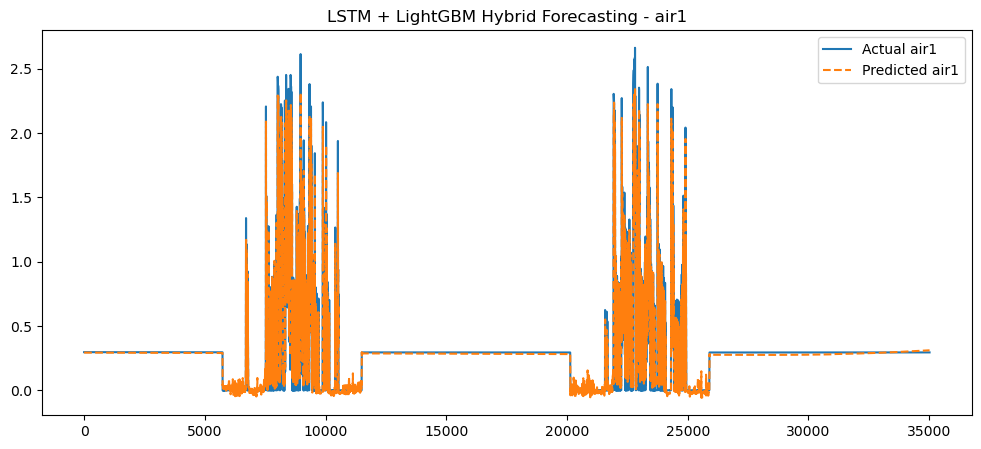

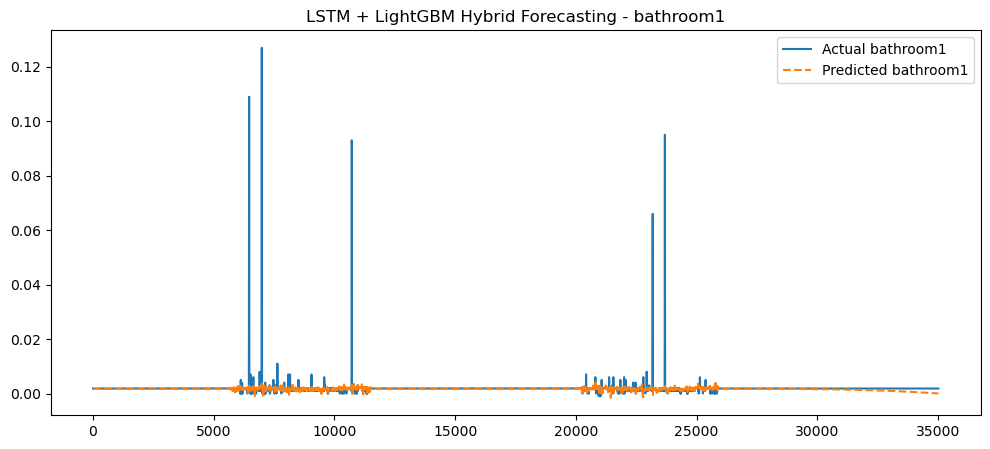

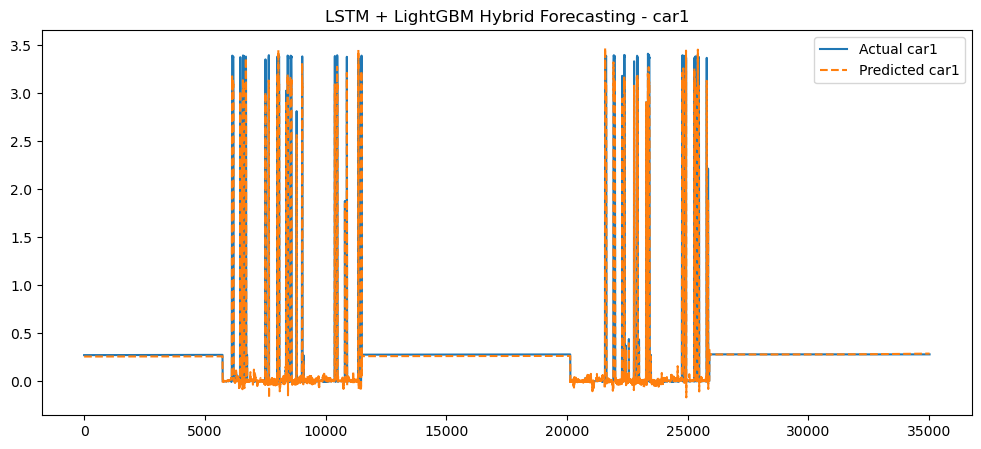

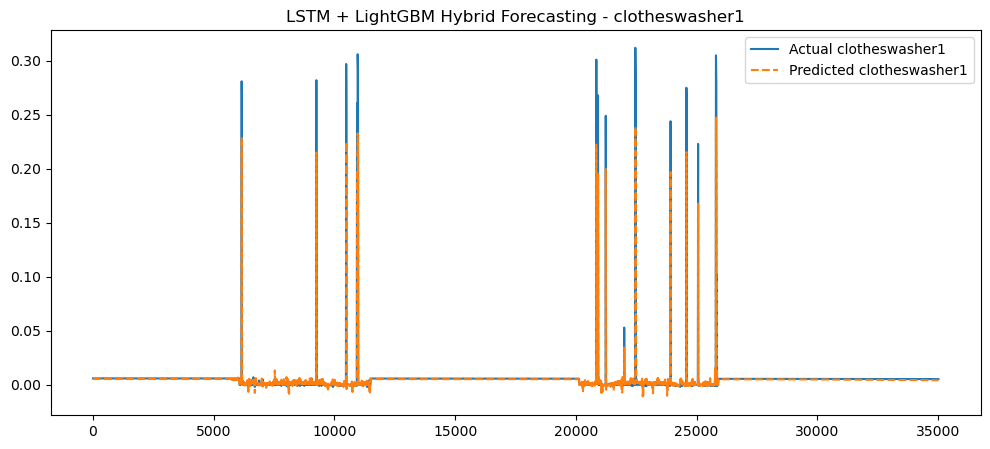

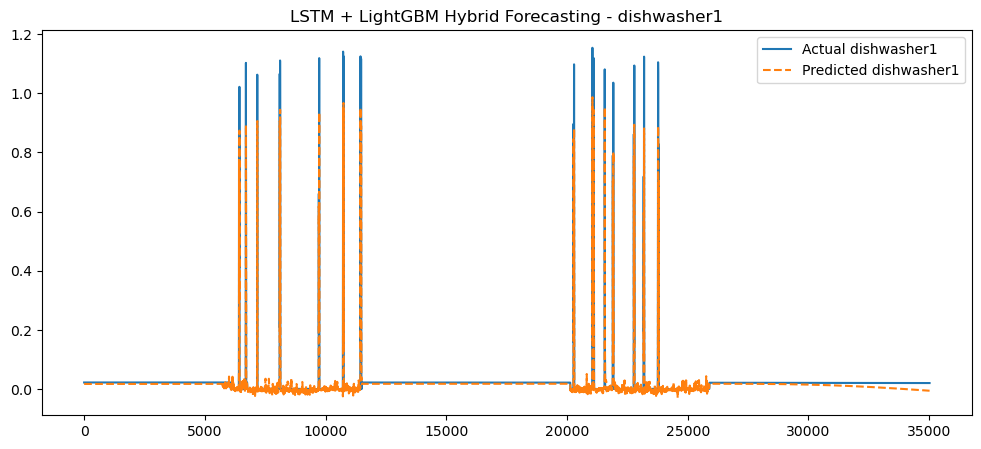

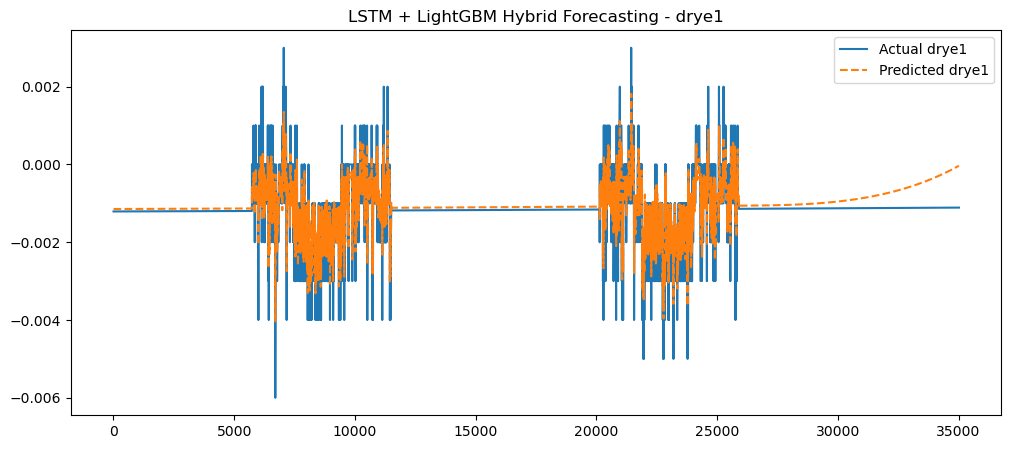

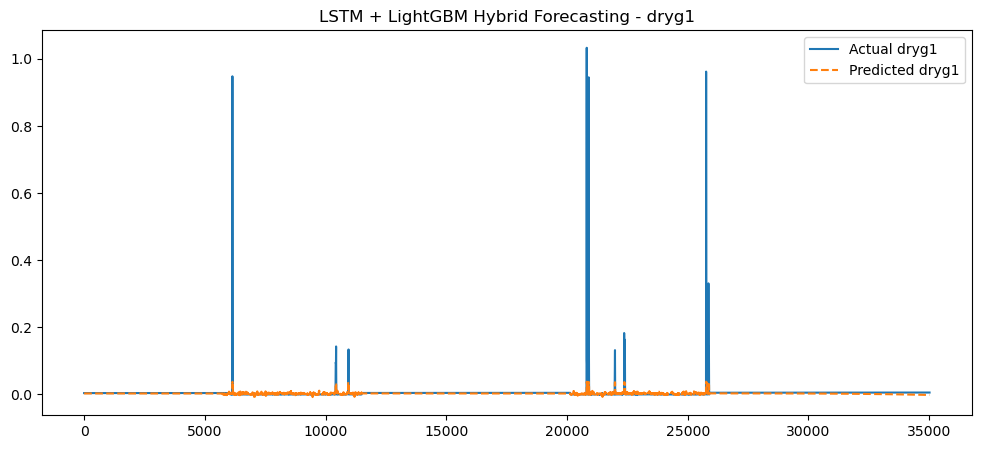

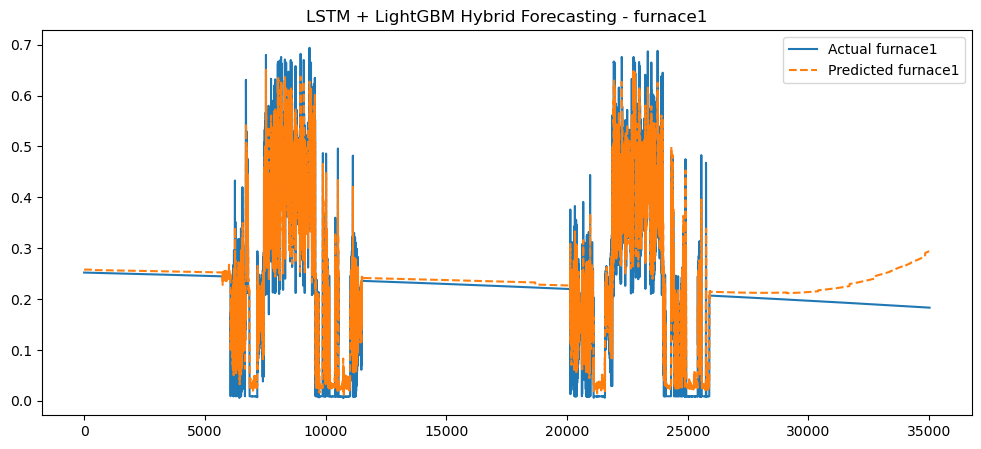

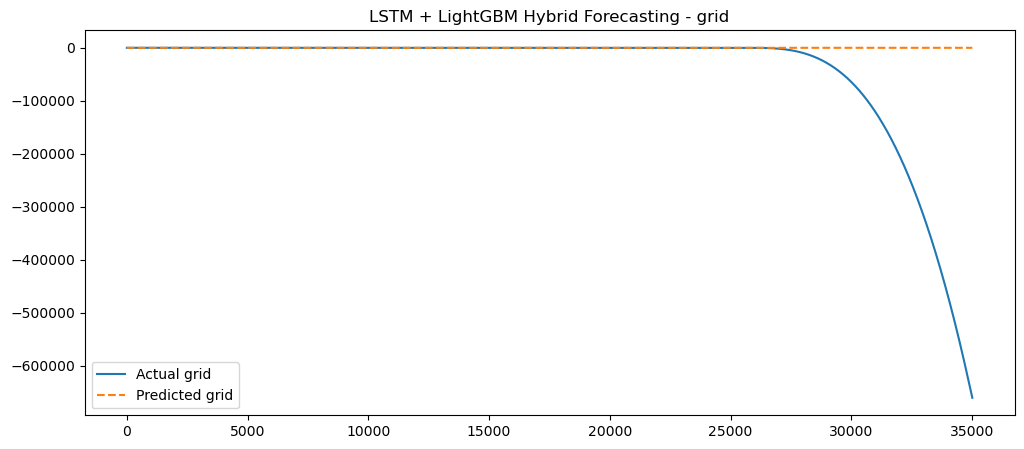

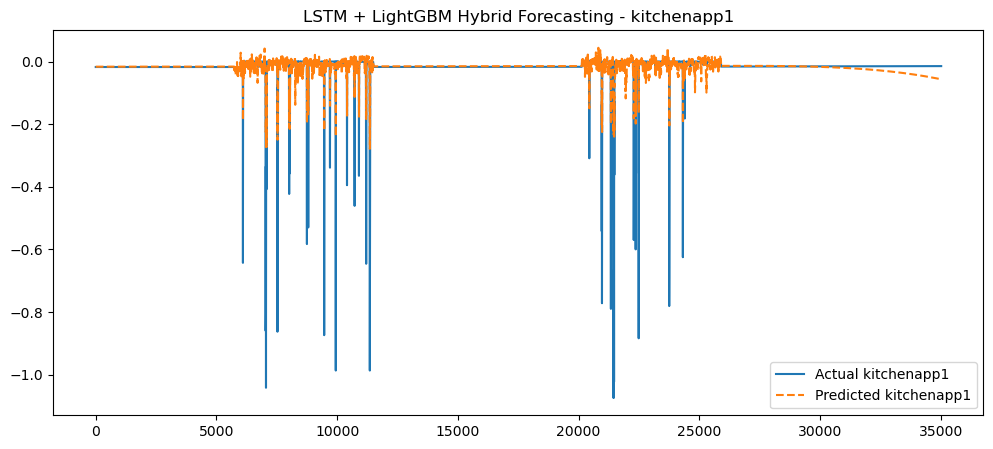

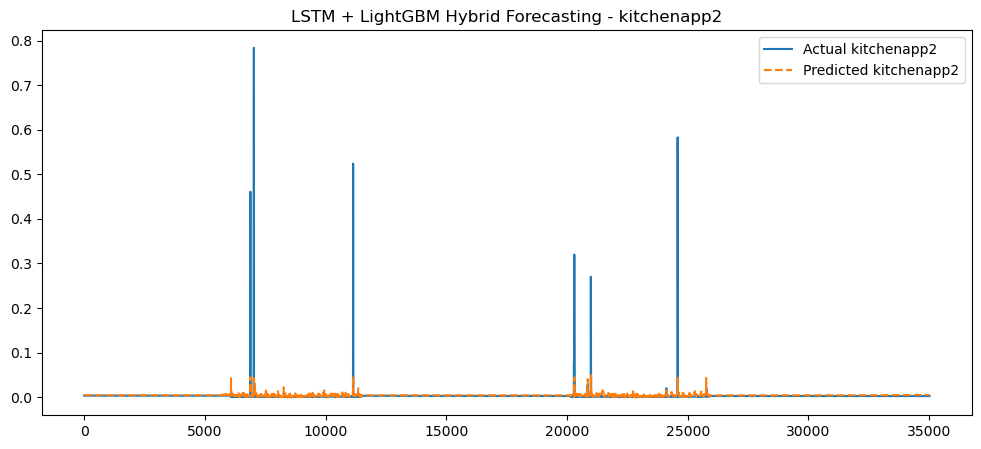

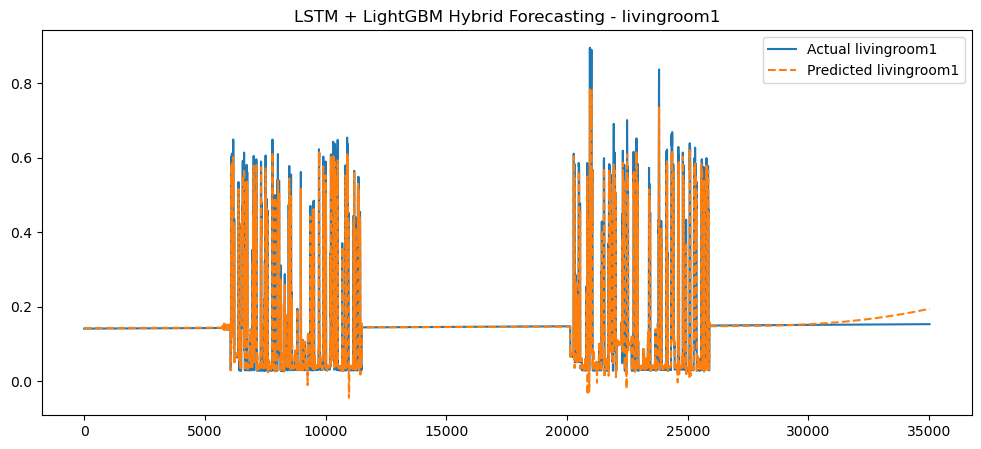

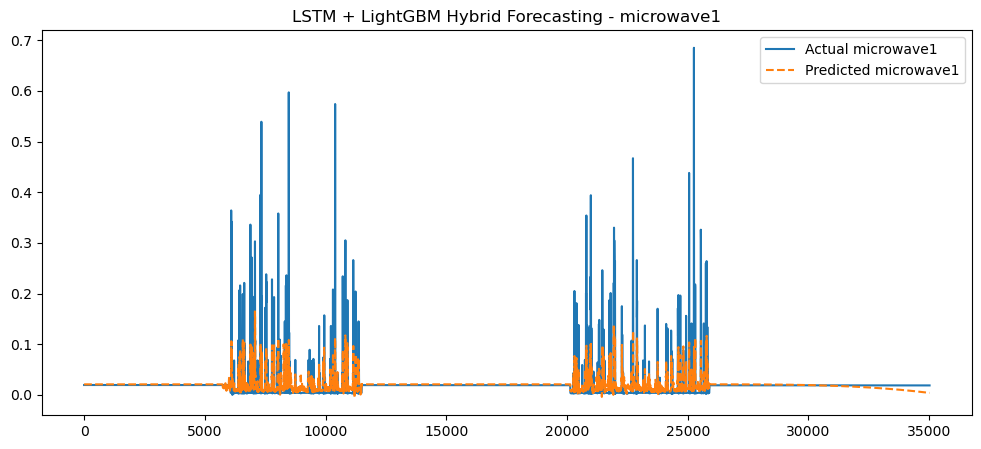

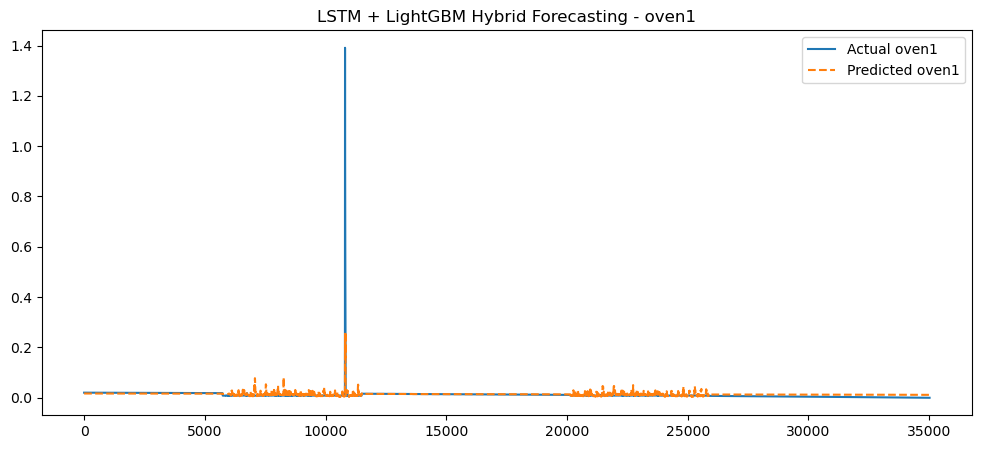

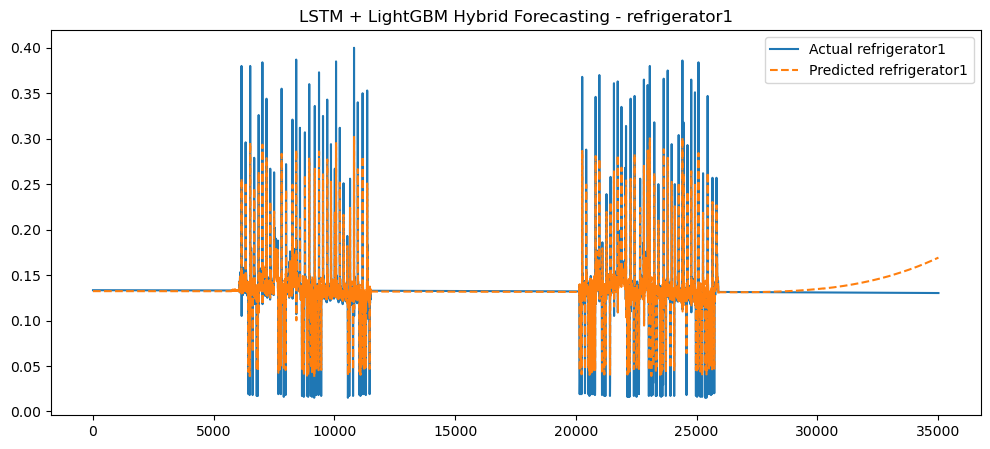

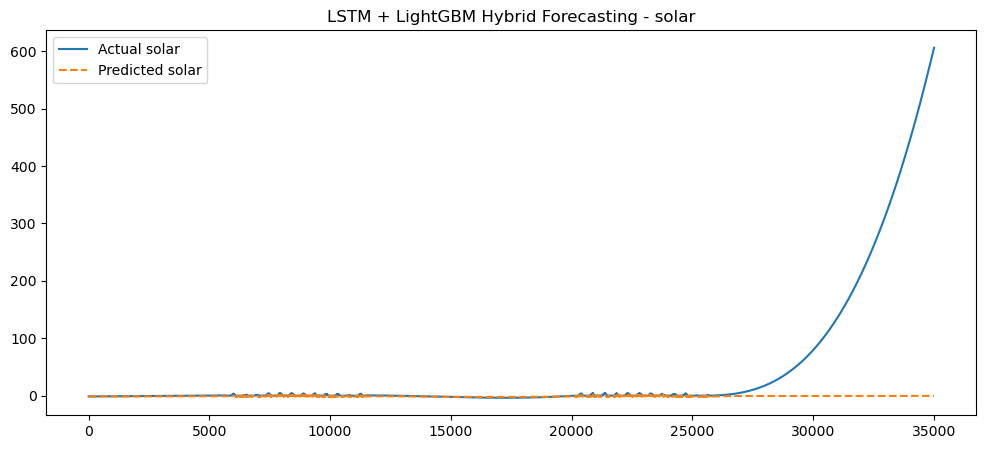

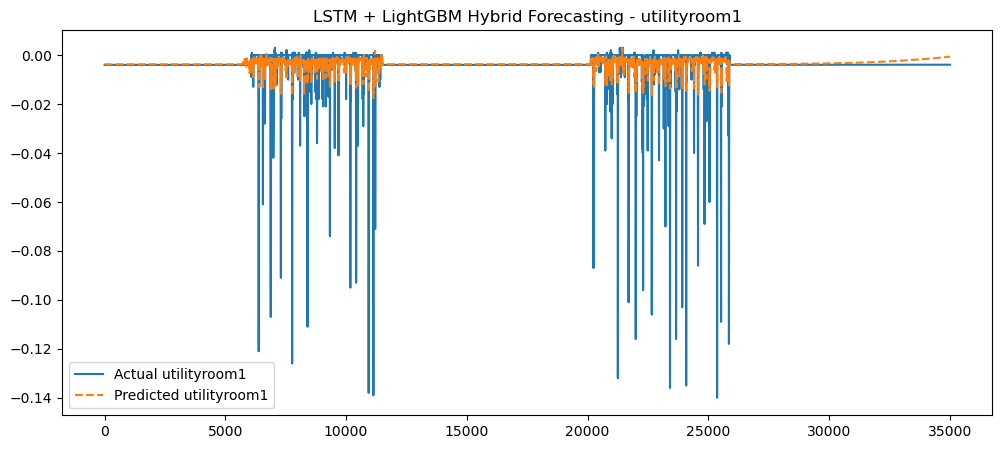

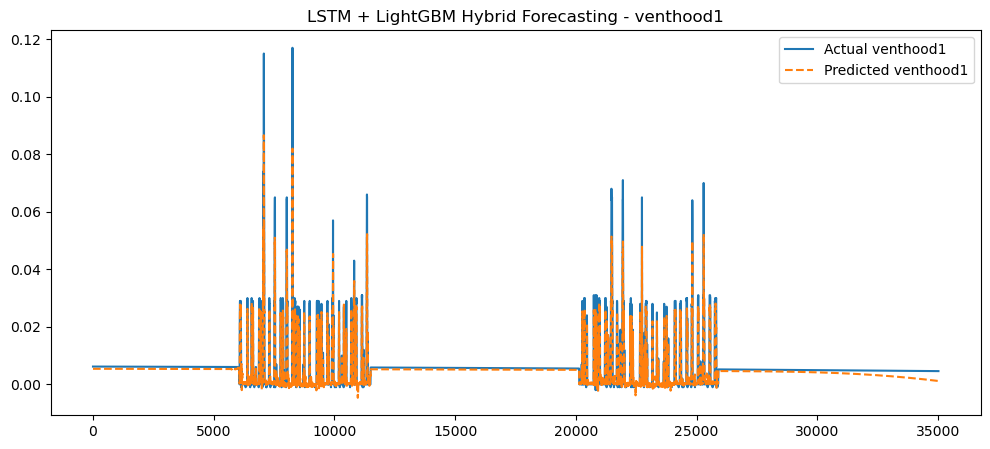

In [26]:


for i in range(len(features)):
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv[:, i], label=f'Actual {features[i]}')
    plt.plot(final_pred[:, i], label=f'Predicted {features[i]}', linestyle='dashed')
    plt.legend()
    plt.title(f'LSTM + LightGBM Hybrid Forecasting - {features[i]}')
    plt.show()

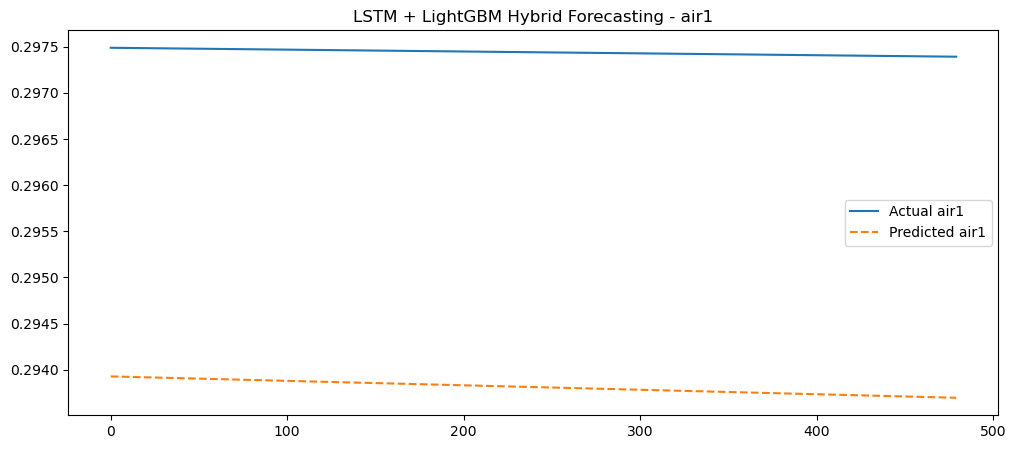

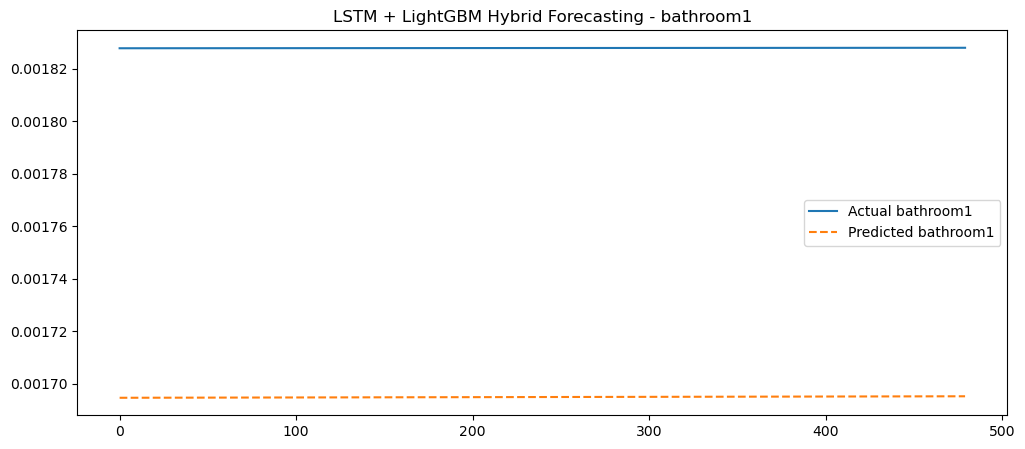

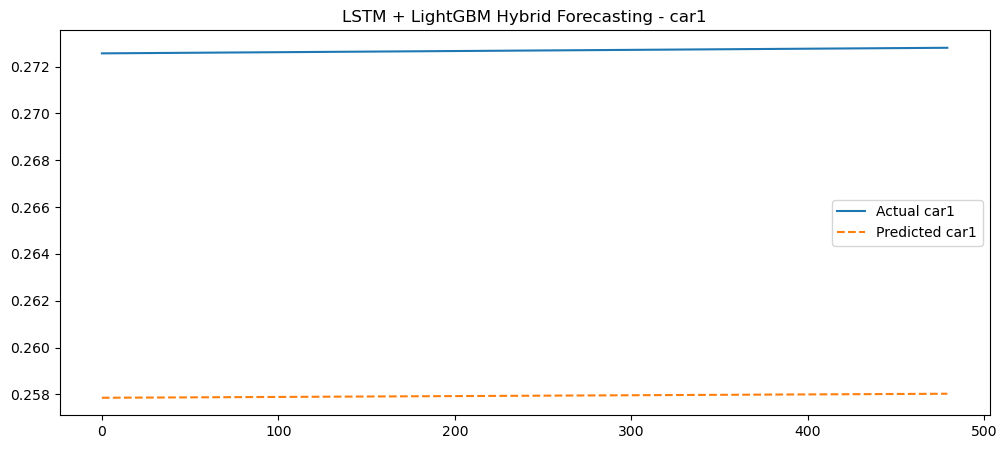

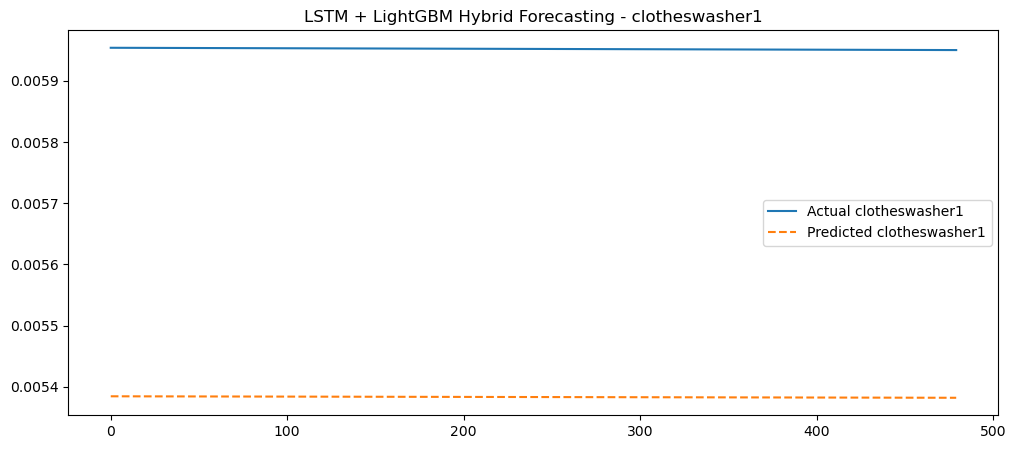

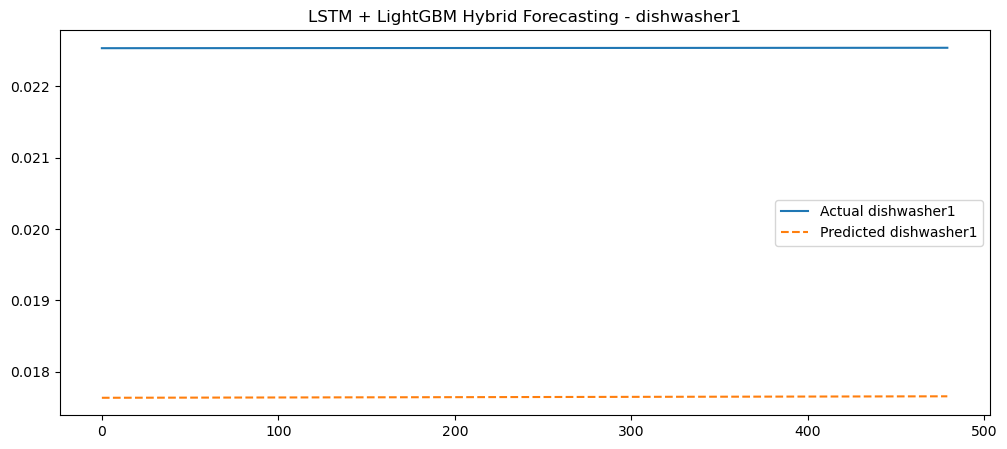

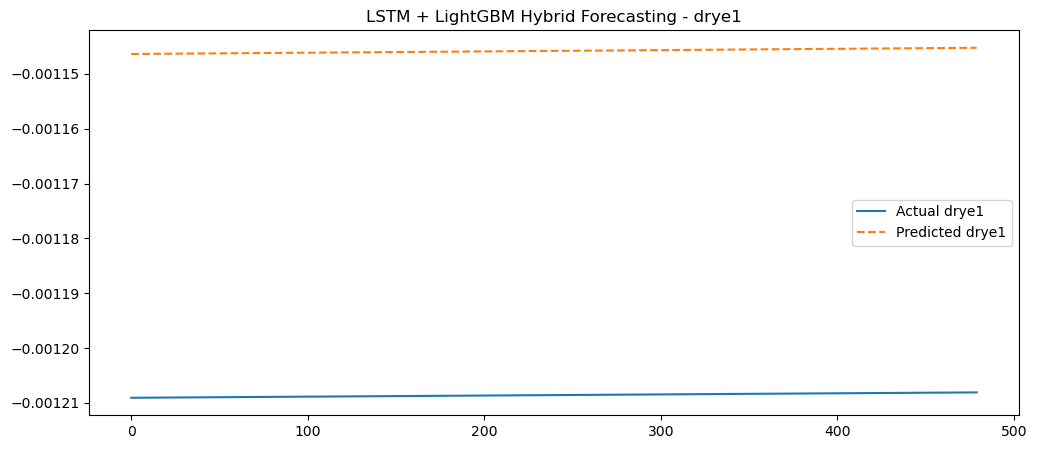

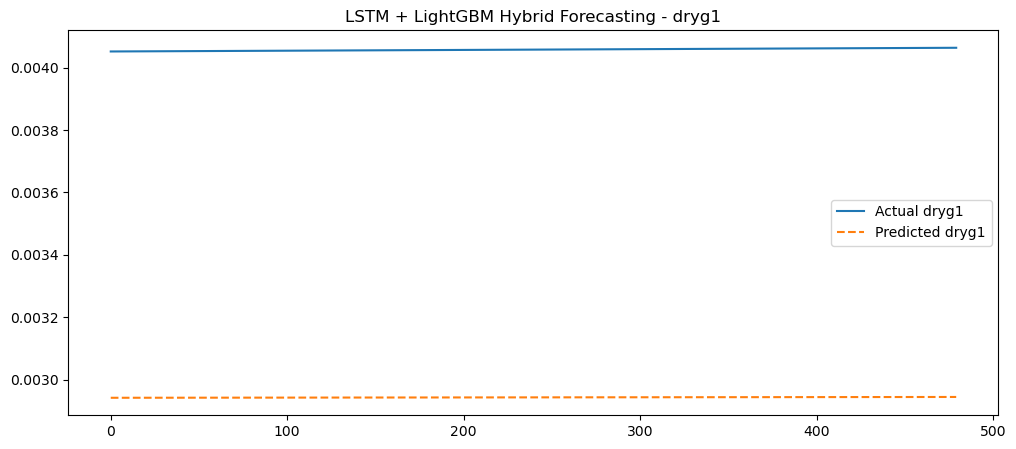

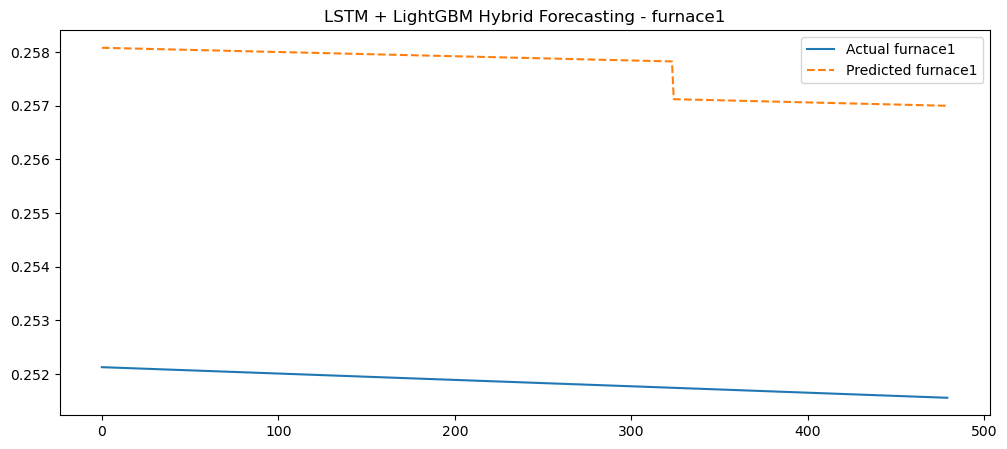

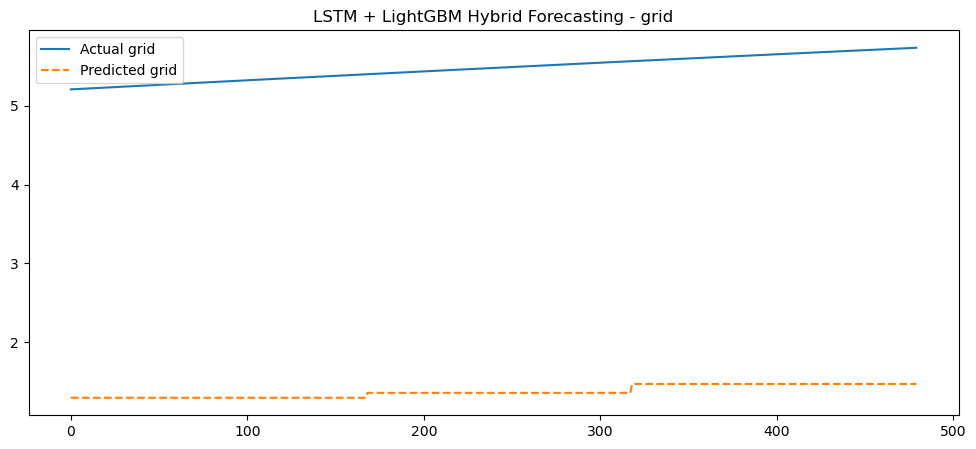

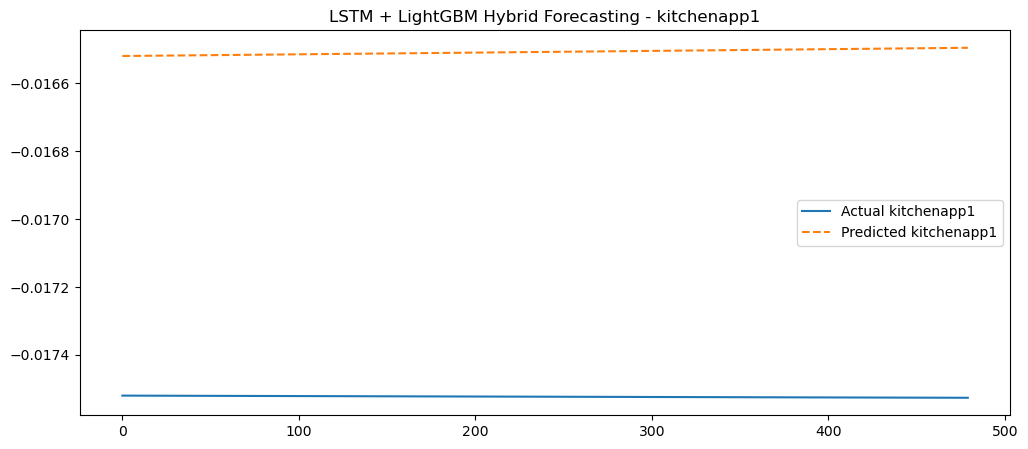

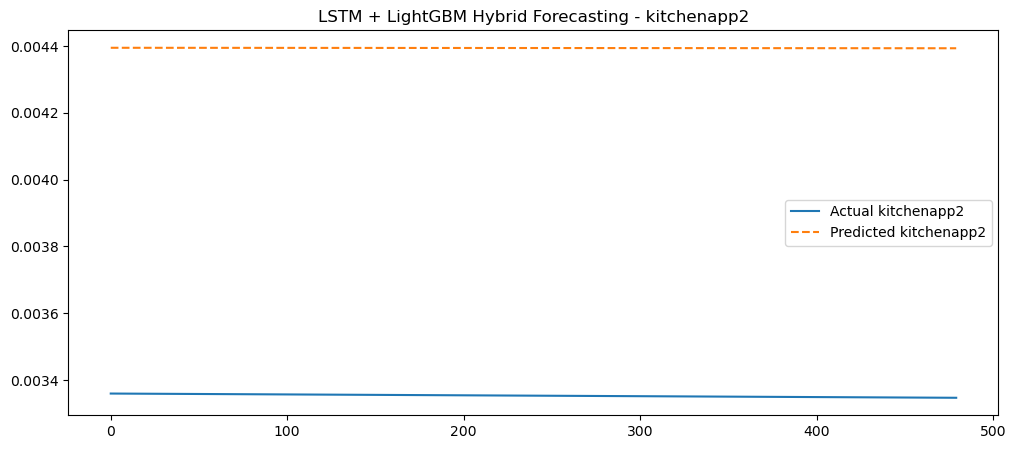

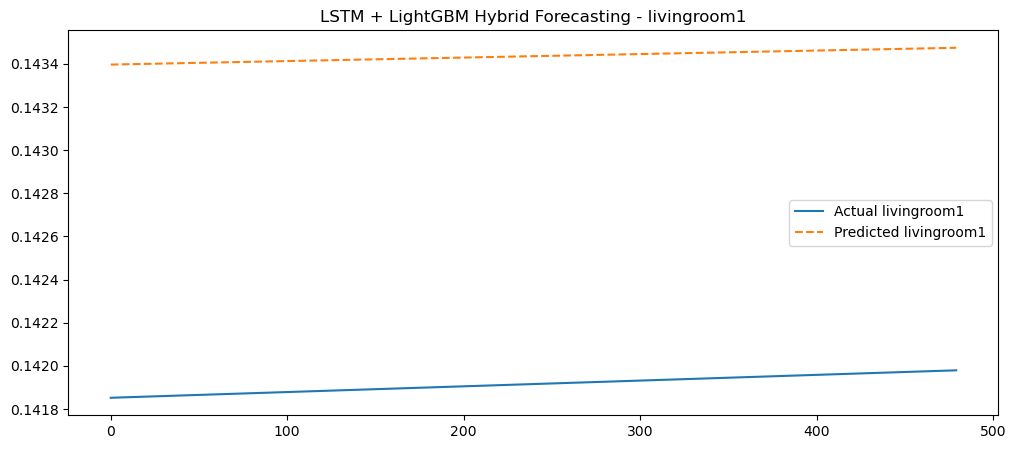

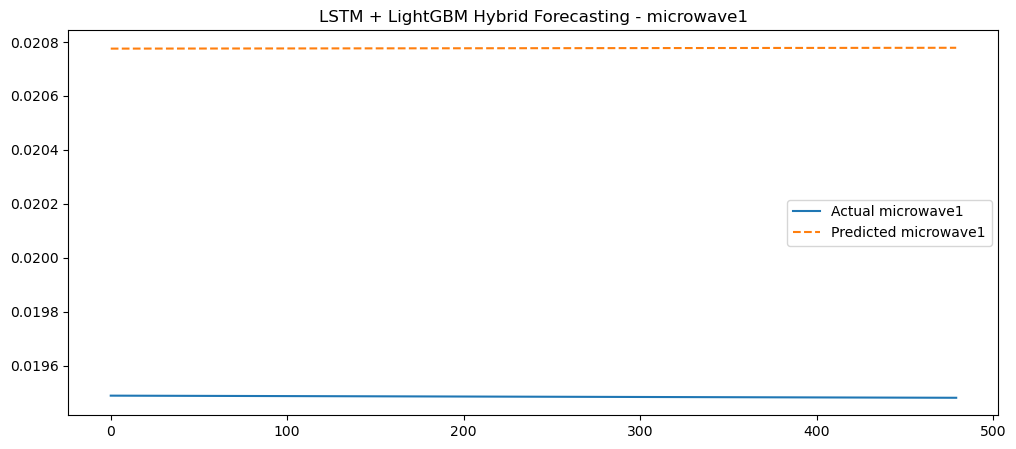

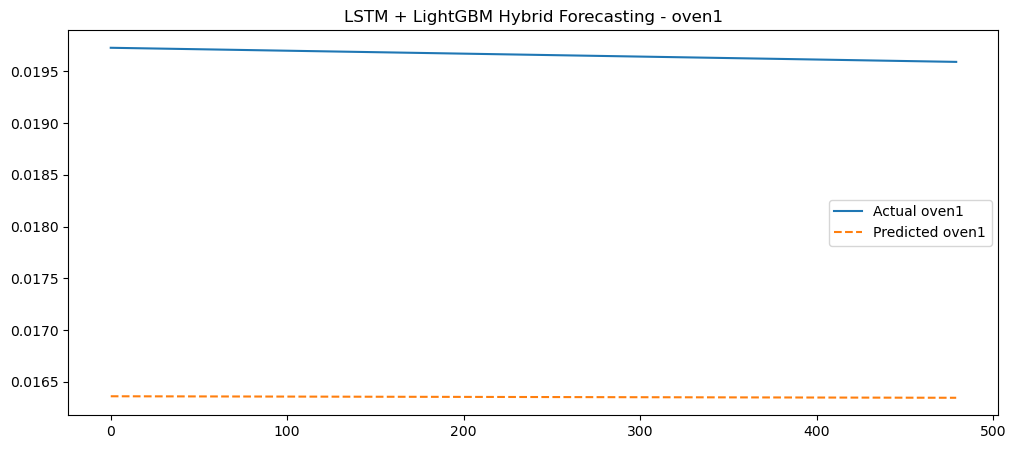

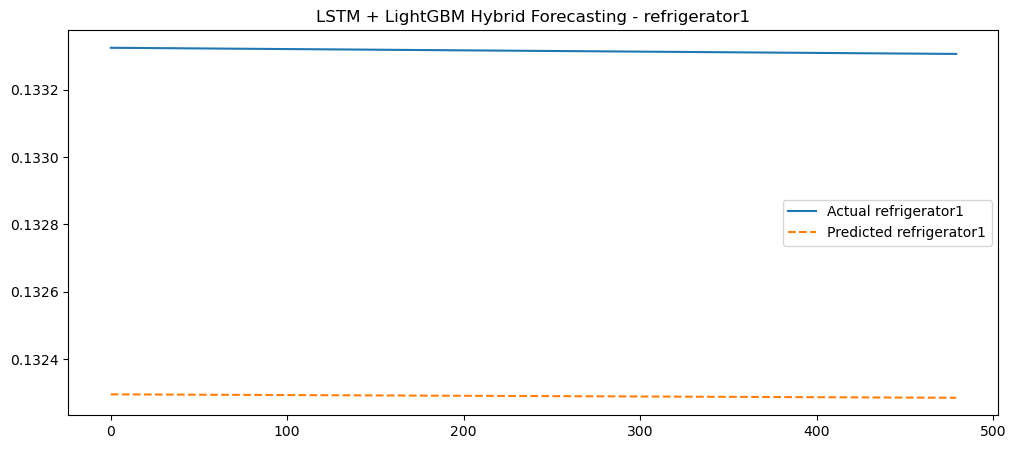

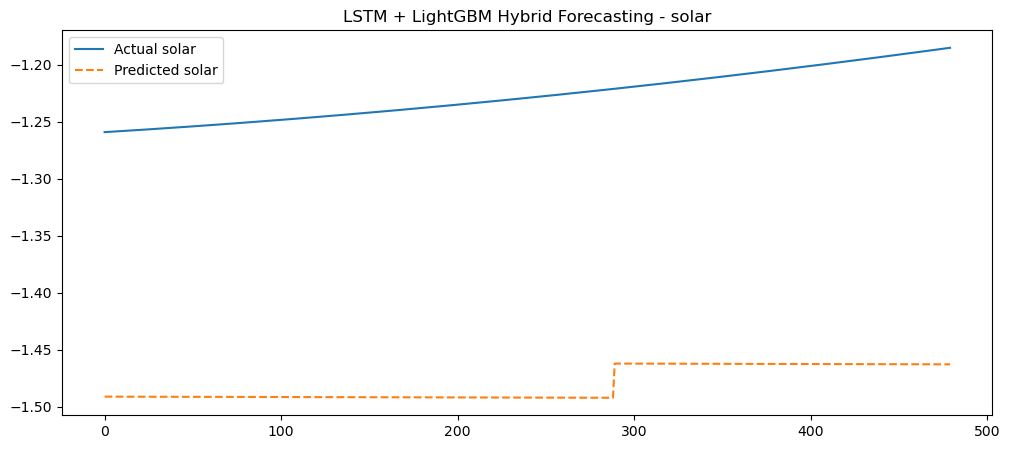

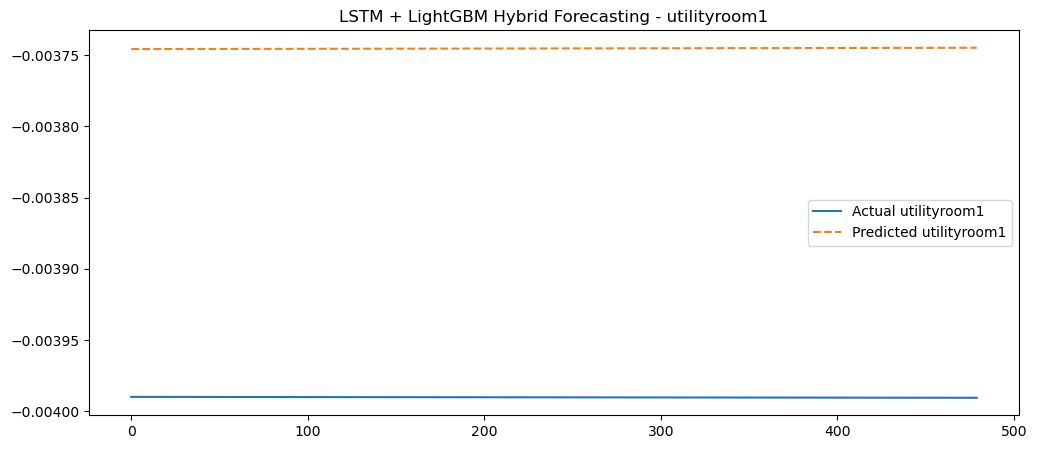

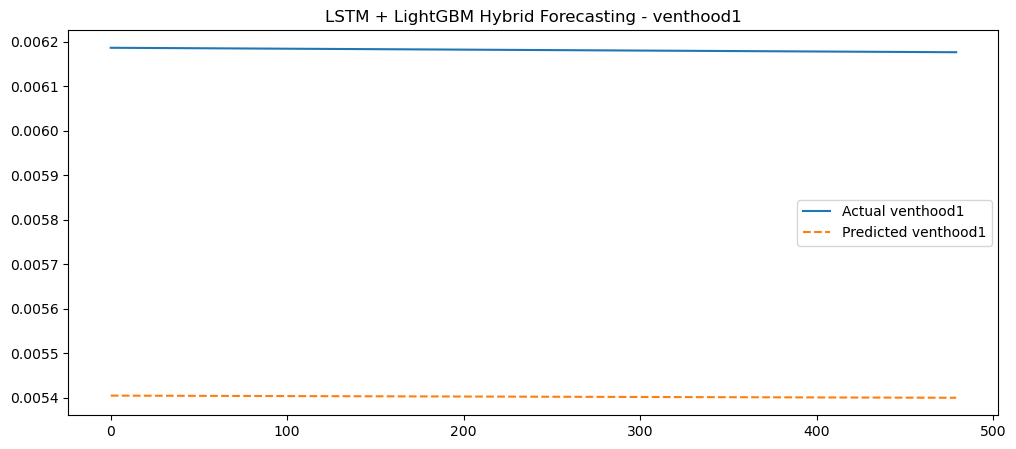

In [27]:
for i in range(len(features)):
    plt.figure(figsize=(12, 5))
    plt.plot(y_test_inv[0:480, i], label=f'Actual {features[i]}')
    plt.plot(final_pred[0:480, i], label=f'Predicted {features[i]}', linestyle='dashed')
    plt.legend()
    plt.title(f'LSTM + LightGBM Hybrid Forecasting - {features[i]}')
    plt.show()


In [35]:
user_date = input("Enter a date (YYYY-MM-DD): ")

Enter a date (YYYY-MM-DD):  2018-10-31


In [36]:
day_data = final_pred_df.loc[user_date]

day_data_act = y_test_df.loc[user_date]



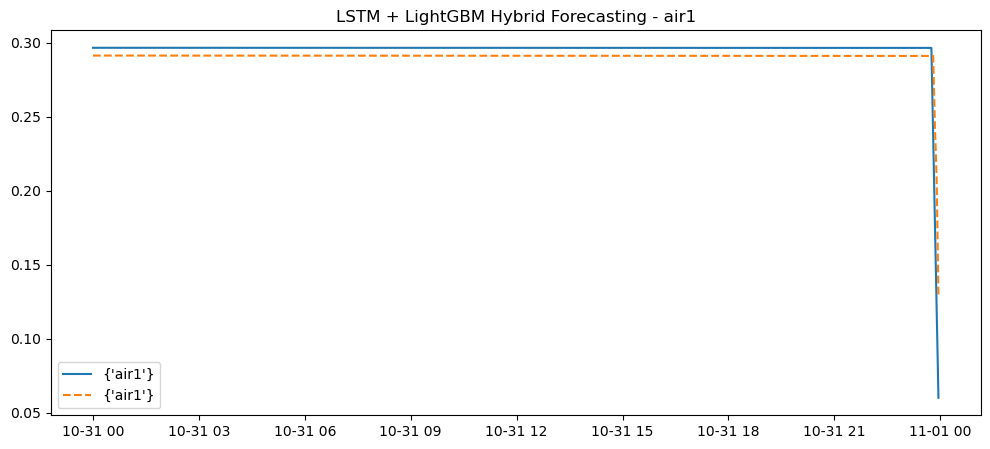

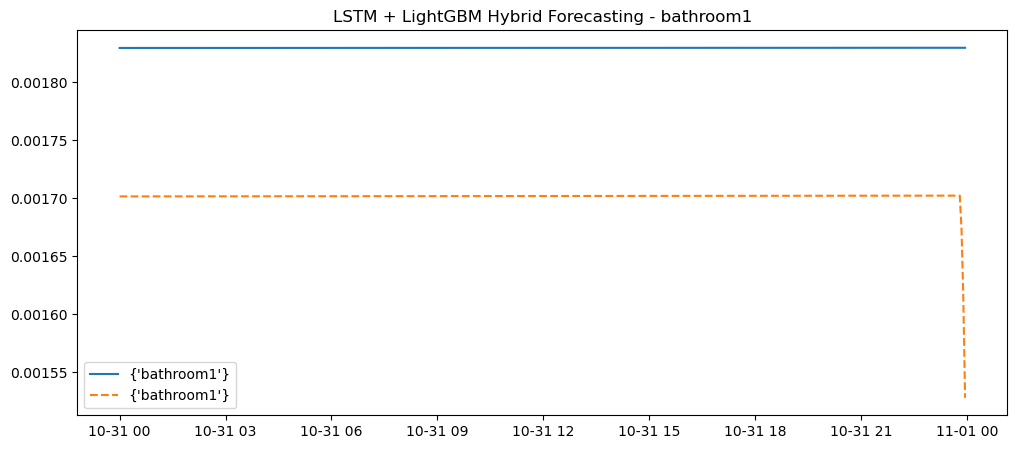

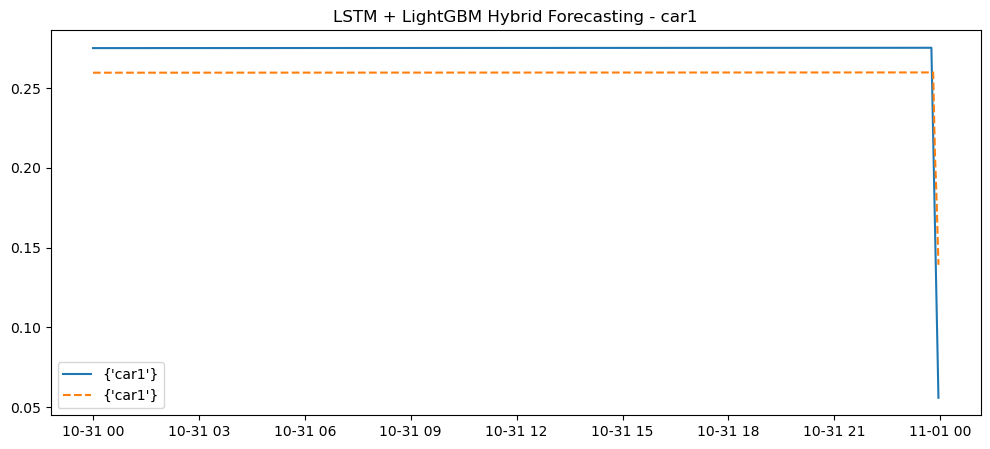

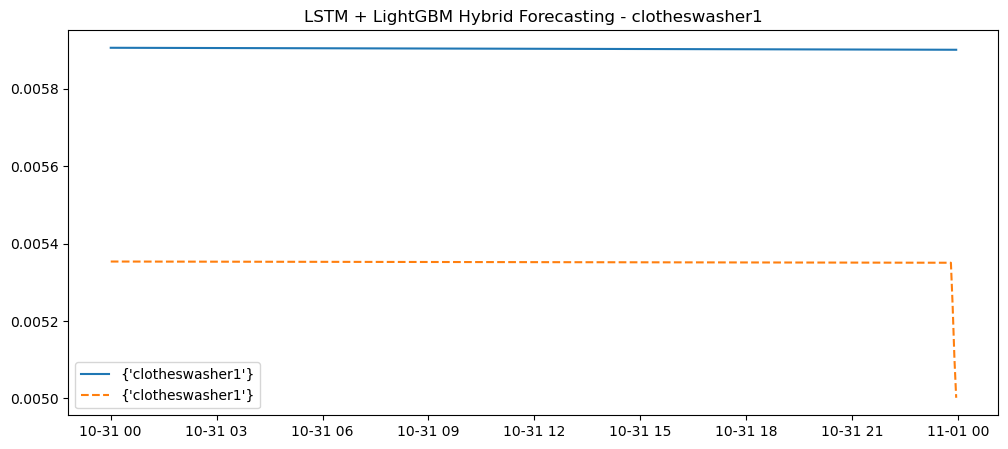

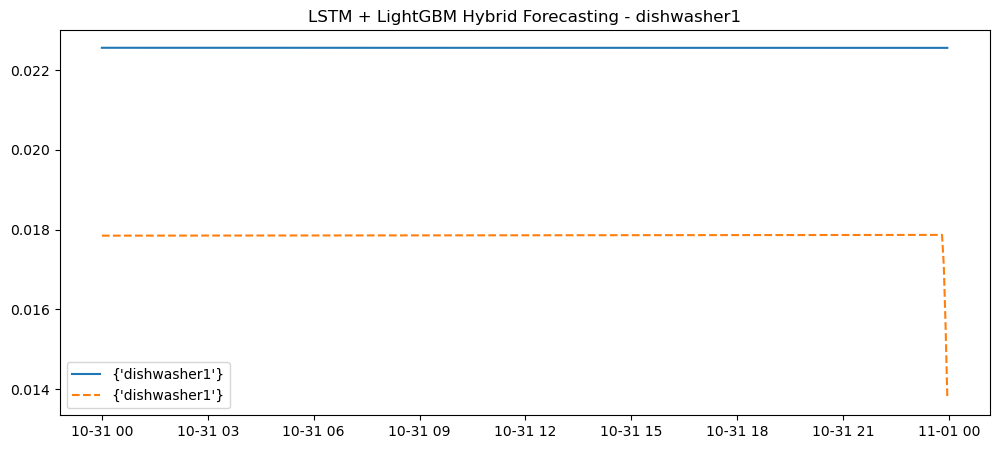

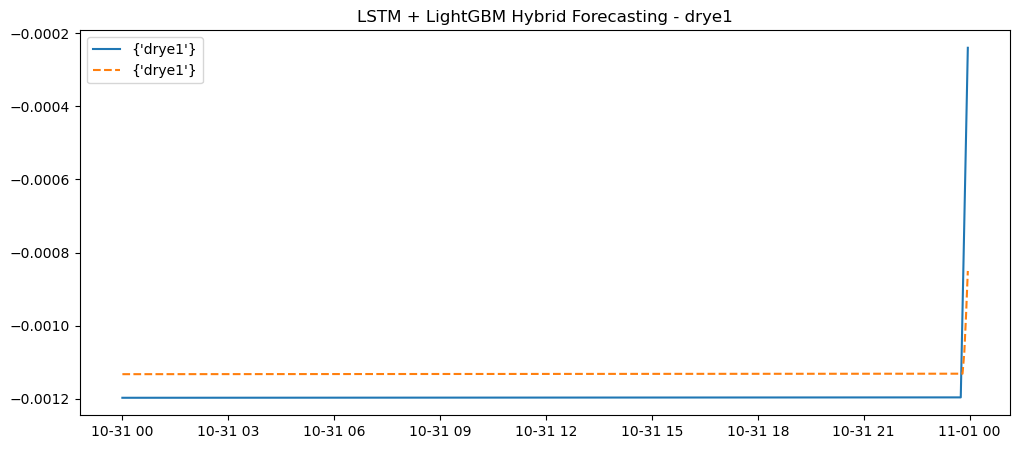

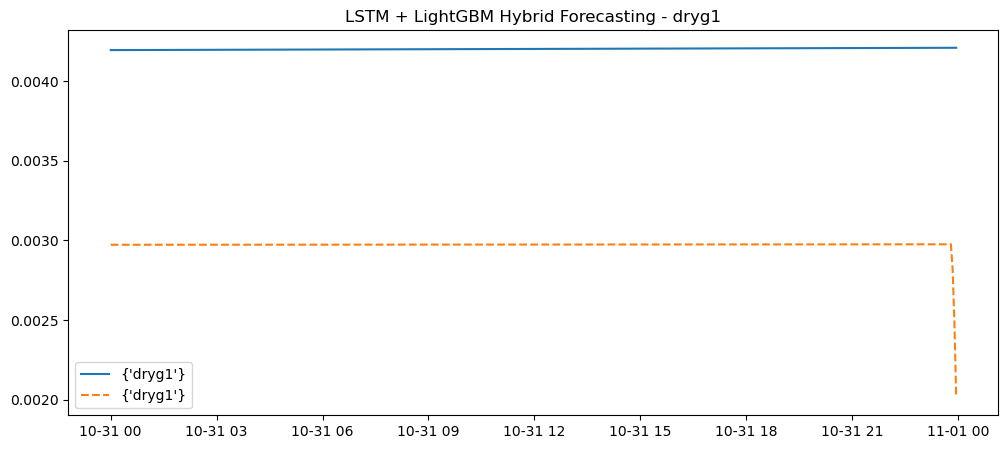

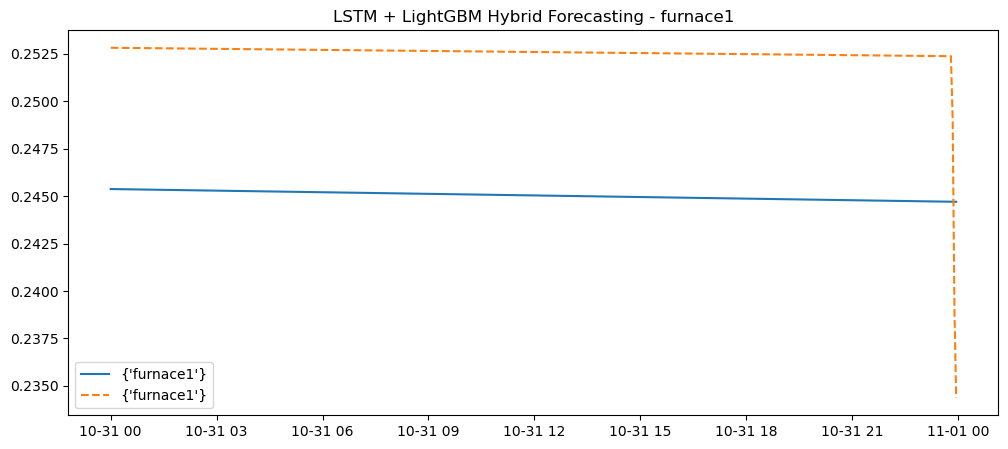

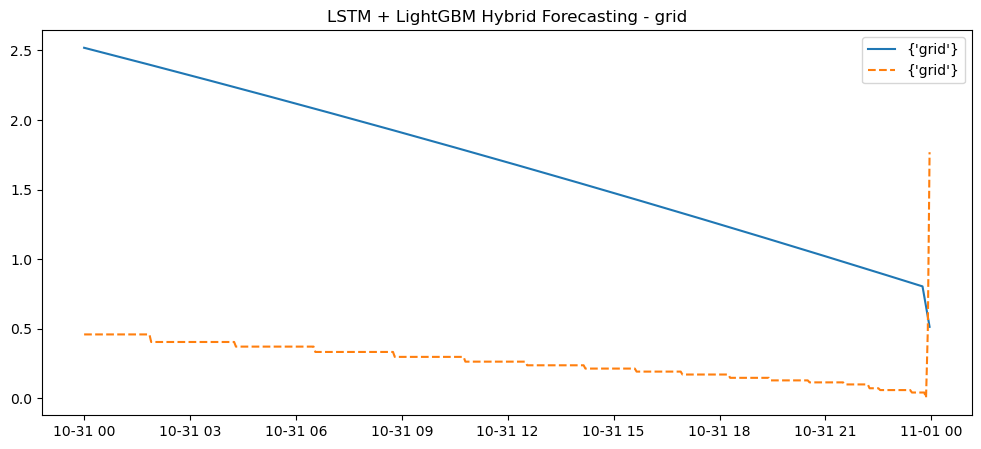

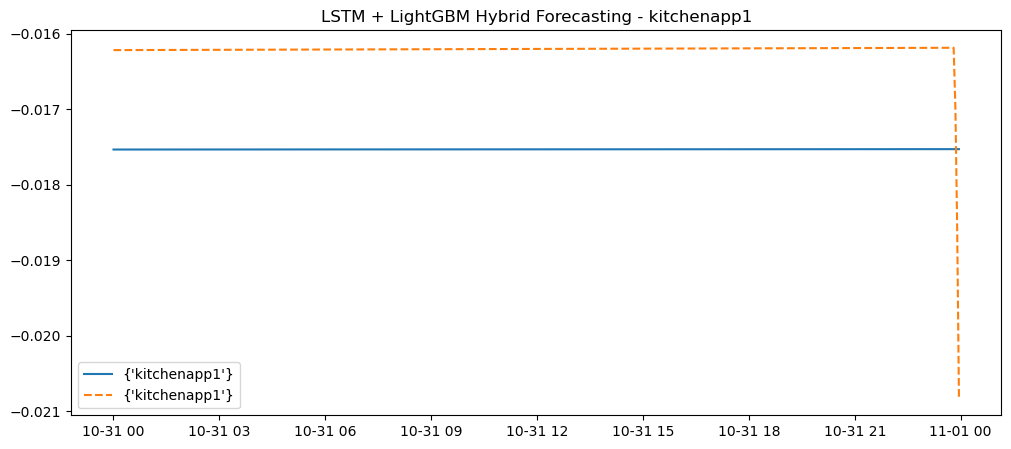

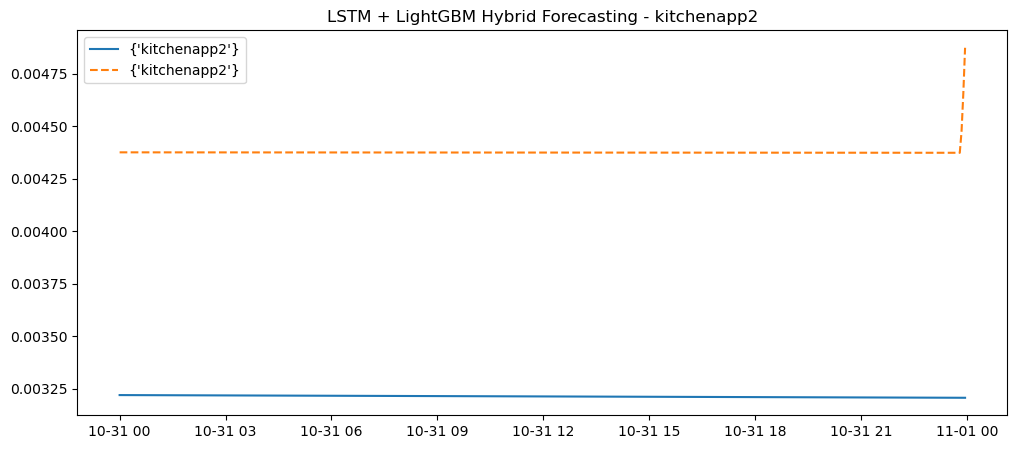

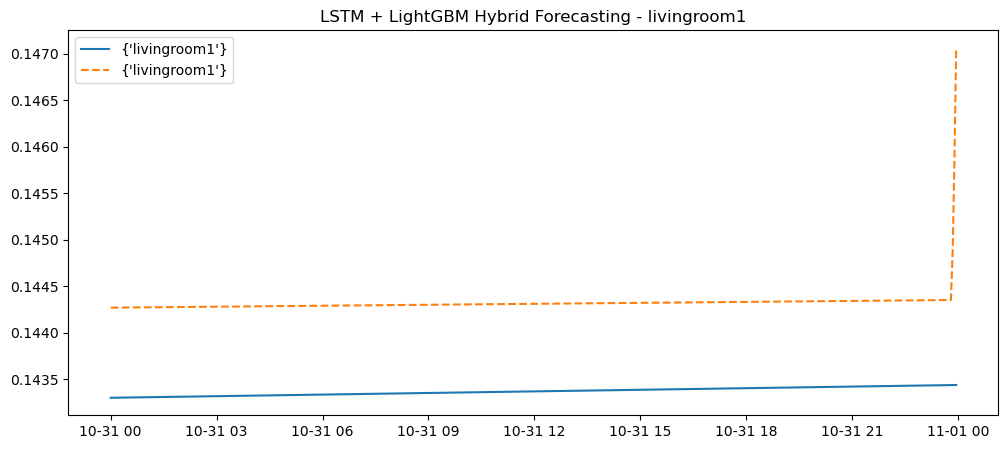

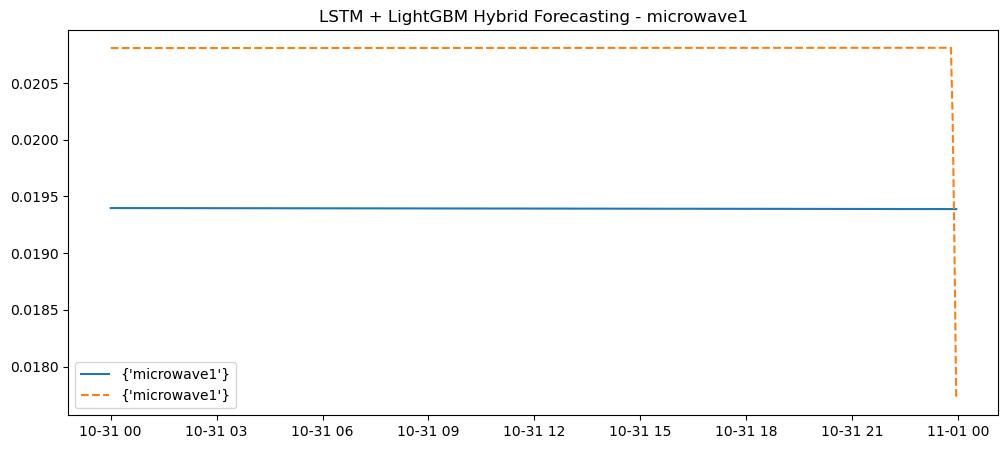

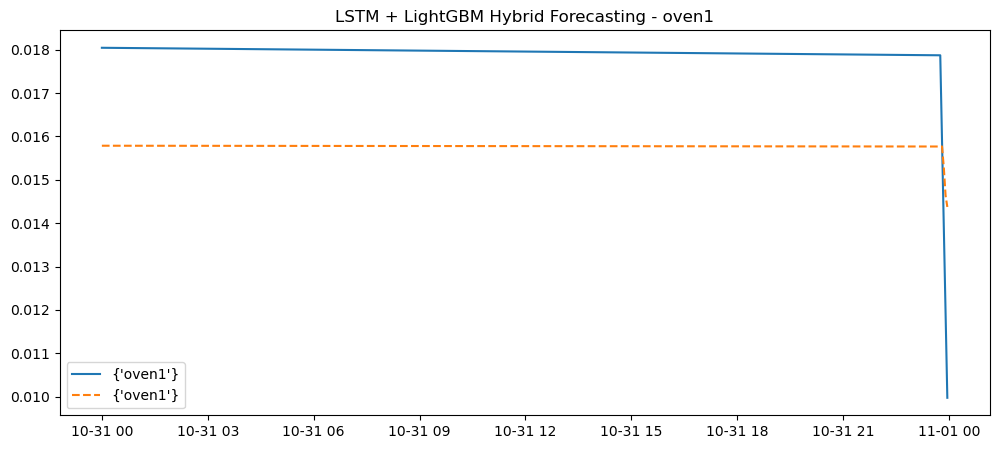

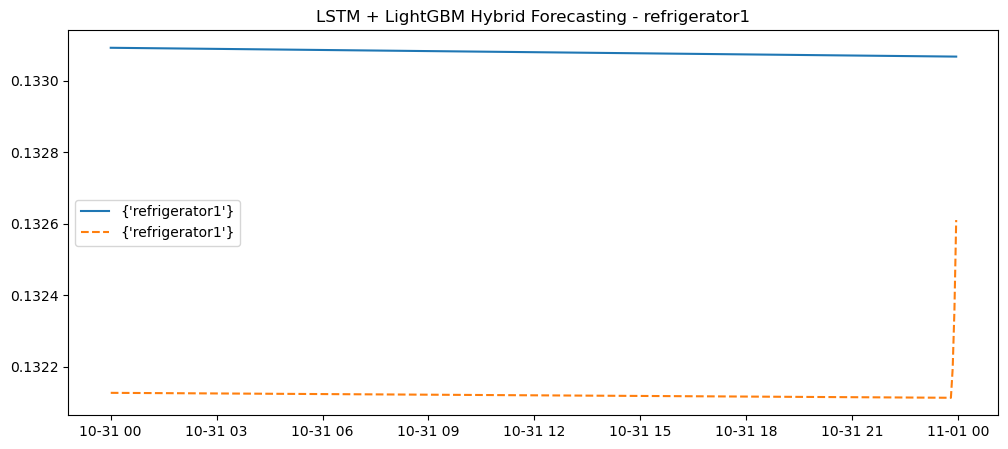

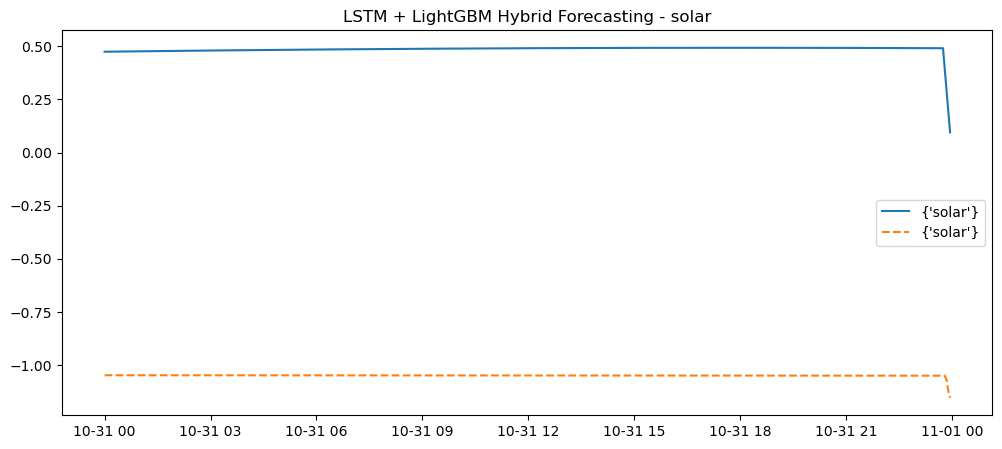

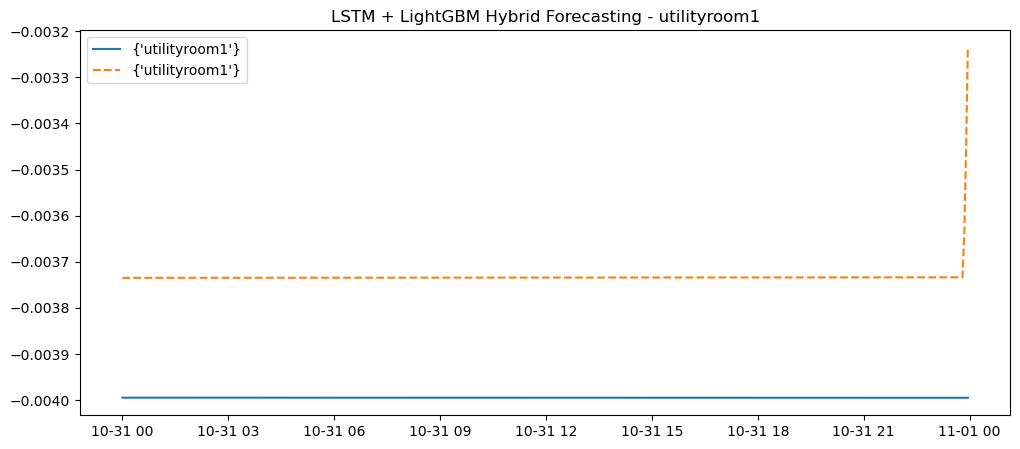

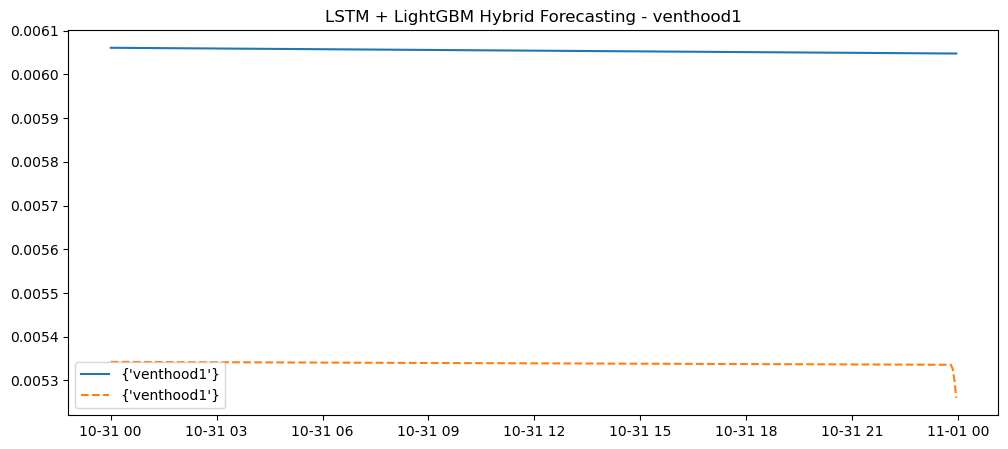

In [37]:
for col in range(len(features)):
    plt.figure(figsize=(12, 5))
    plt.plot(day_data_act.index, day_data_act[col], label={features[col]})
    plt.plot(day_data.index, day_data[col], label={features[col]}, linestyle='dashed')
    plt.legend()
    plt.title(f'LSTM + LightGBM Hybrid Forecasting - {features[col]}')
    plt.show()
